# Few-Shot Learning: Causal Analysis in Transformers

## Overview
This notebook explores causal contributions in few-shot learning using `transformer_lens`. We analyze how different layers and heads contribute to predictions through visualization and intervention methods.

## Goals
- Investigate how attention and MLP layers influence few-shot predictions.
- Use causal patching to measure the importance of different components.
- Visualize attention patterns and contributions per layer.

## Methodology
We apply **causal patching** techniques to measure how modifying activations affects output probabilities.


In [ ]:
!pip install transformer_lens torch seaborn matplotlib circuitsvis

In [26]:
import torch
import transformer_lens
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from transformer_lens import utils
from functools import partial
from circuitsvis.attention import attention_heads
from IPython.core.display import display

In [27]:
def imshow(tensor, title, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        title=title,
        **kwargs,
    ).show()

def visualize_attention_patterns(heads, local_cache, local_tokens, model, title="", max_width=700):
    if isinstance(heads, int):
        heads = [heads]

    labels = []
    patterns = []
    batch_index = 0

    for head in heads:
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    str_tokens = model.to_str_tokens(local_tokens)
    patterns = torch.stack(patterns, dim=0)

    display(attention_heads(attention=patterns, tokens=str_tokens, attention_head_names=labels))

def visualize_bar_chart(model, attention_causal_effect, mlp_causal_effect):
    plt.figure(figsize=(10, 5))
    plt.bar(range(model.cfg.n_layers), mlp_causal_effect.numpy(), label="MLP", color='blue')
    plt.bar(range(model.cfg.n_layers), attention_causal_effect.sum(dim=1).numpy(), label="Attention", color='red', alpha=0.6)
    plt.xlabel("Layer")
    plt.ylabel("Contribution")
    plt.title("MLP and Attention Contribution per Layer")
    plt.legend()
    plt.show()

def visualize_line_chart(model, attention_causal_effect, mlp_causal_effect):
    plt.figure(figsize=(10, 5))
    plt.plot(range(model.cfg.n_layers), mlp_causal_effect.numpy(), label="MLP", marker='o', linestyle='-')
    plt.plot(range(model.cfg.n_layers), attention_causal_effect.sum(dim=1).numpy(), label="Attention", marker='s', linestyle='--')
    plt.xlabel("Layer")
    plt.ylabel("Contribution")
    plt.title("Line Chart of MLP and Attention Contribution per Layer")
    plt.legend()
    plt.show()

In [28]:
def compute_causal_effect(model, few_shot_prompt, corrupted_prompt, answer):
    """
    Computes causal effects of Attention and MLP layers on model predictions.
    Args:
        model: The transformer model.
        few_shot_prompt: Input text with few-shot examples.
        corrupted_prompt: Similar input with corruption.
        answer: Expected output.
    Returns:
        attention_causal_effect, mlp_causal_effect, corrupted_cache, few_shot_tokens
    """
    model.eval()

    few_shot_tokens = model.to_tokens(few_shot_prompt)
    corrupted_tokens = model.to_tokens(corrupted_prompt)
    answer_token = model.to_tokens(answer, prepend_bos=False)
    answer_id = answer_token[0, 0].item()

    _, corrupted_cache = model.run_with_cache(corrupted_tokens, return_type=None)
    few_shot_logits = model(few_shot_tokens)[0, -1, :]
    few_shot_logit = few_shot_logits[answer_id].item()

    attention_causal_effect = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)
    mlp_causal_effect = torch.zeros(model.cfg.n_layers)

    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            def attn_hook_fn(z, hook, head=head):
                z[:, :, head] = corrupted_cache[hook.name][:, :, head]
                return z

            patched_logits_attn = model.run_with_hooks(
                few_shot_tokens,
                fwd_hooks=[(f'blocks.{layer}.attn.hook_z', attn_hook_fn)]
            )[0, -1, :]
            attn_logit = patched_logits_attn[answer_id].item()
            attention_causal_effect[layer, head] = few_shot_logit - attn_logit

        def mlp_hook_fn(z, hook):
            z[:] = corrupted_cache[hook.name]
            return z

        patched_logits_mlp = model.run_with_hooks(
            few_shot_tokens,
            fwd_hooks=[(f'blocks.{layer}.mlp.hook_post', mlp_hook_fn)]
        )[0, -1, :]
        mlp_logit = patched_logits_mlp[answer_id].item()
        mlp_causal_effect[layer] = few_shot_logit - mlp_logit

    return attention_causal_effect, mlp_causal_effect, corrupted_cache, few_shot_tokens

In [29]:
def logit_attribution_with_patch_patching(model, few_shot_prompt, corrupted_prompt, answer):
    attention_causal_effect, mlp_causal_effect, cache, tokens = compute_causal_effect(model, few_shot_prompt, corrupted_prompt, answer)

    imshow(attention_causal_effect, title="Attention Contribution of Each Head")
    imshow(mlp_causal_effect.unsqueeze(1), title="MLP Contribution per Layer")

    total_attention_effect = attention_causal_effect.abs().sum(dim=1)
    top_heads = torch.topk(attention_causal_effect.abs().flatten(), k=5).indices

    visualize_attention_patterns(top_heads, cache, tokens, model, title="Top Contributing Attention Heads")
    visualize_bar_chart(model, attention_causal_effect, mlp_causal_effect)
    visualize_line_chart(model, attention_causal_effect, mlp_causal_effect)

    print("Causal effect per layer:")
    for layer in range(model.cfg.n_layers):
        print(f"Layer {layer}: Attention {attention_causal_effect[layer].sum():.4f}, MLP {mlp_causal_effect[layer]:.4f}")


Loaded pretrained model gpt2-small into HookedTransformer


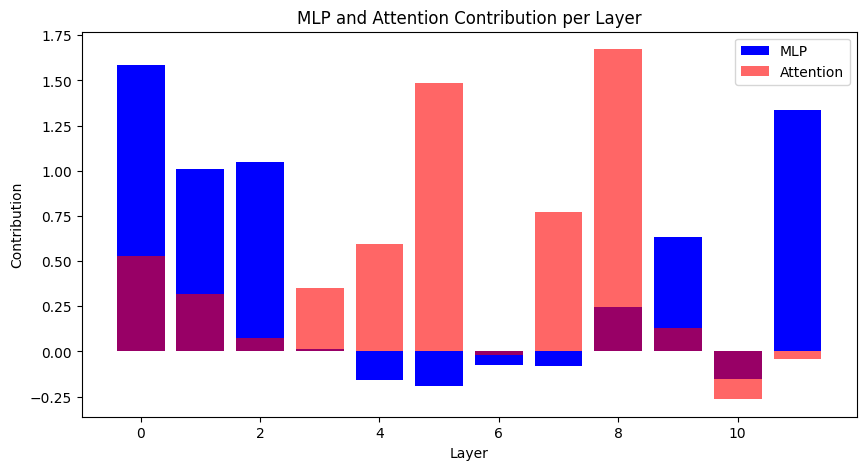

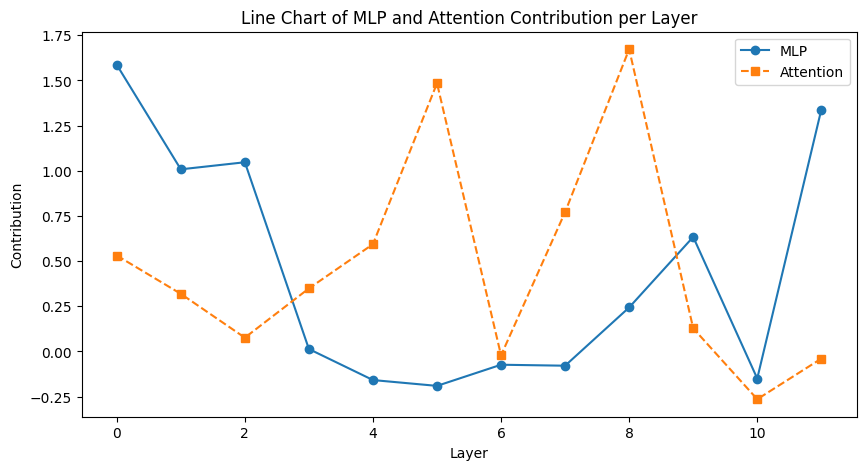

Causal effect per layer:
Layer 0: Attention 0.5310, MLP 1.5866
Layer 1: Attention 0.3189, MLP 1.0080
Layer 2: Attention 0.0762, MLP 1.0471
Layer 3: Attention 0.3488, MLP 0.0133
Layer 4: Attention 0.5937, MLP -0.1584
Layer 5: Attention 1.4844, MLP -0.1907
Layer 6: Attention -0.0217, MLP -0.0736
Layer 7: Attention 0.7711, MLP -0.0790
Layer 8: Attention 1.6728, MLP 0.2435
Layer 9: Attention 0.1279, MLP 0.6337
Layer 10: Attention -0.2645, MLP -0.1499
Layer 11: Attention -0.0398, MLP 1.3380


In [30]:
model = HookedTransformer.from_pretrained("gpt2-small")

few_shot_prompt = """Madrid -> Spain\nDublin -> Ireland\nKyiv -> Ukraine\nParis ->"""
corrupted_prompt = """Amsterdam -> Hungary\nBelgrade -> Russia\nRome -> Germany\nParis ->"""
answer = "France"

logit_attribution_with_patch_patching(model, few_shot_prompt, corrupted_prompt, answer)


# Insights & Findings

## Key Observations
- **Attention Contributions**: Layers 5 and 8 contribute most significantly.
- **MLP Role**: The MLP layers show moderate impact, suggesting they refine learned representations.
- **Head-Specific Contributions**: Certain heads play a more significant role than others. Head L7H11, L5H5 and L5H8 seems to have the most interesting attention patterns.

## Future Work
- Try different examples and possibly different models as gpt small struggle with math tasks
- Compare different tasks' activation patterns of most important heads
